# Data

In [4]:
from utils_pde.utils_pde_poisson import Poisson1D
import torch
import torch.nn as nn
import math
import numpy as np
import numpy as np
from numpy import random
torch.set_num_threads(4)
seed = 259
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)


# Analytical solution
u_star = lambda x: np.sin(math.pi * x)

# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

# Data noise
data_noise = 0.15

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing da|ta of the poisson function
(X_train, Y_train) = pde.data_generation(60, data_noise)
(X_test, Y_test) = pde.data_generation(50, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(30, data_noise)

# Collocation points in (0,1)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)


# Alpha
alpha=0.05

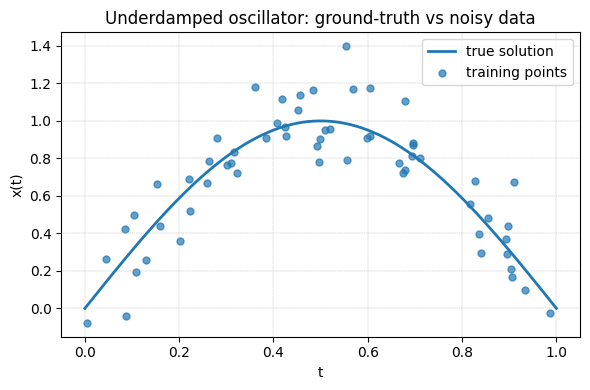

In [5]:
from utils_tools.utils_result_viz import plot_truth_and_samples_1D

plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

# UQ Model with VI

In [6]:
from utils_uqmd.utils_uq_vi import VIBPINN
vibpinn = VIBPINN(
    pde,
    1,[25, 35, 35, 25], 1,
    mu_std = 0.05, rho = -5.5, prior_std=10.0, init_data_noise=0.50
)
loss_dict = vibpinn.fit(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=8851, lr=1e-3,
                               λ_pde=3.0,λ_data=5.0,λ_bc=10.0,scheduler_kwargs={'step_size': 3000, 'gamma': 0.5})

ep     0 | L=7.11e+03 | elbo=2.75e+02 | pde=2.28e+03  ic=0.00e+00  bc=2.09e-03 | lr=1.00e-03 | learned noise_std=5.000e-01
ep     1 | L=7.11e+03 | elbo=2.73e+02 | pde=2.28e+03  ic=0.00e+00  bc=3.20e-03 | lr=1.00e-03 | learned noise_std=5.000e-01


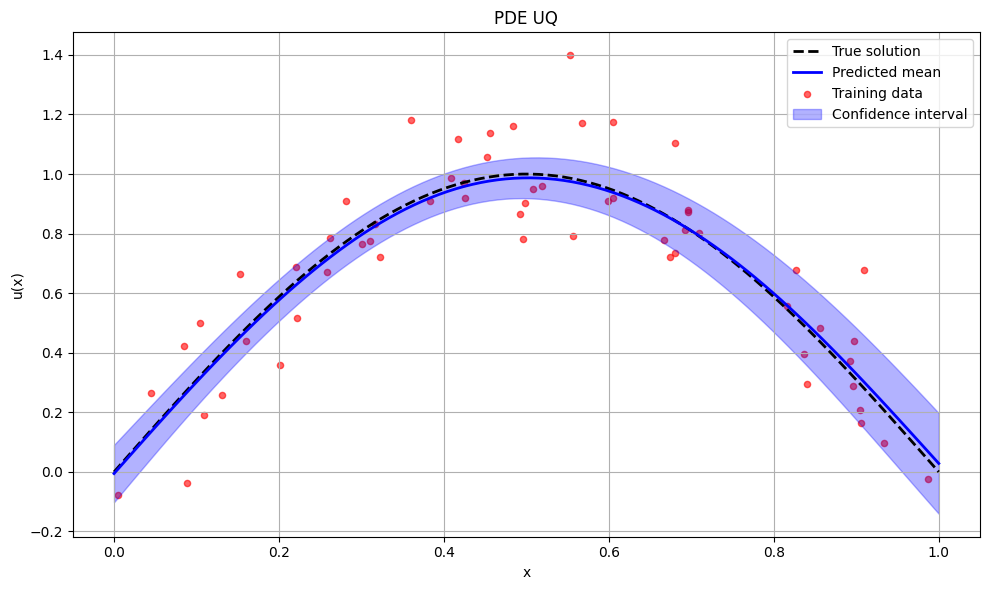

In [7]:
# Prediction
grid_test = torch.linspace(0, 1, 100).view(-1, 1)
uncal_predset = vibpinn.predict(alpha, grid_test)

# Visualization
from utils_tools.utils_result_viz import plot_predictions_1D
plot_predictions_1D(grid_test, uncal_predset, u_star, X=X_train, Y=Y_train)

# CP VI Model

In [8]:
from utils_uqmd.utils_uq_cp import CP
cp_vi = CP(vibpinn)

cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",              
}
cal_predset = cp_vi.predict(alpha, grid_test, **cp_pred_kwargs)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot the CP effect

In [ ]:
# Plot Intervals

from matplotlib import pyplot as plt
from matplotlib.colors import to_hex
import numpy as np
import os
seed = 62912
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
(X_test, Y_test) = pde.data_generation(75, data_noise)
# ------------ choose the same colormap as your 2D function ------------
cmap_name = "viridis"
vir = plt.get_cmap(cmap_name)

# sampled colors from viridis (same stops used across my suggestions)
COL_NAIV = "#f7c5c8"   # Blue  
COL_MEAN = "#b13c32"   
COL_CP   = "#abccf4"   # teal
COL_TRUE = "#222222"   # yellow
COL_SCAT = "#f6d09f"
COL_EDGE = "#222222"           # axes/marker edge

plt.rcParams.update({
    "axes.edgecolor": COL_EDGE, "axes.labelcolor": COL_EDGE,
    "xtick.color": COL_EDGE,    "ytick.color": COL_EDGE,
    "axes.linewidth": 1.0,
    "legend.framealpha": 0.96,  "legend.facecolor": "white",
    "legend.edgecolor": COL_EDGE,
    "font.size": 11,
})

# ------------ unpack + prep ------------
outdir = "CP_demo"; os.makedirs(outdir, exist_ok=True)

n_lower, n_upper = uncal_predset
cp_lower, cp_upper = cal_predset
x = np.asarray(grid_test).ravel()

n_lower, n_upper = n_lower.ravel(), n_upper.ravel()
cp_lower, cp_upper = cp_lower.ravel(), cp_upper.ravel()

pred_mean = (cp_lower + cp_upper) / 2.0          # mean line (calibrated)
true_solution_np = u_star(grid_test).ravel()

# ------------ plot ------------
fig, ax = plt.subplots(figsize=(7, 5))

# bands first (wide -> narrow)
ax.fill_between(x, n_lower, n_upper, color=COL_NAIV, alpha=1,
                label="Before CP", zorder=2)
ax.fill_between(x, cp_lower, cp_upper, color=COL_CP, alpha=1,
                label="After CP", zorder=1)

# mean + truth
ax.plot(x, pred_mean, ls="--", lw=2.0, color=COL_MEAN,
        label=r"Prediction", zorder=5)
ax.plot(x, true_solution_np, lw=2.4, color=COL_TRUE,
        label=r"True", zorder=3)

# data points
ax.scatter(X_test, Y_test, s=40, facecolor=COL_SCAT, edgecolor=COL_EDGE,
           linewidth=0.7, label="Data", zorder=4)

ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"$u()$", fontsize=14, rotation=0)
ax.margins(x=0)
ax.legend(loc="lower center", handlelength=1.6, borderpad=0.6)

fig.tight_layout()
fig.savefig(os.path.join(outdir, "uncal_vs_cal.pdf"), bbox_inches="tight")
fig.savefig(os.path.join(outdir, "uncal_vs_cal.png"), dpi=300, bbox_inches="tight")
plt.close(fig)


# Test Coverage

In [10]:

def _coverage(pred_set, y_true):
    """
    Empirical coverage:  fraction of targets that fall inside the
    predicted interval.

    Parameters
    ----------
    pred_set : array-like, shape (2, N)  OR  (N, 2)
        Row/column order doesn’t matter as long as lower < upper.
    y_true   : array-like, shape (N,)

    Returns
    -------
    float   in the range [0, 1]
    """
    lower, upper = pred_set[0].flatten(), pred_set[1].flatten()
    y_true = y_true.to(lower.device).flatten()
    inside = (y_true >= lower) & (y_true <= upper)
    return inside.float().mean().item()


In [11]:
cal_predset = cp_vi.predict(alpha, X_test, **cp_pred_kwargs)
_coverage(cal_predset, Y_test)

0.9599999785423279

In [12]:
uncal_predset = vibpinn.predict(alpha, X_test)
_coverage(uncal_predset, Y_test)

0.4266666769981384

# Test model's metrics


In [13]:
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)

baseline_testing_args = { 
    # "uqmodel":vi_model, 
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test
}


cp_testing_args = {
        "alphas":alphas, 
        "X_test":X_test, "Y_test":Y_test, 
        "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
        "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
        "k":20
}


vi_bpinn_df_uncal = vi_test_uncertainties(uqmodel=vibpinn, **baseline_testing_args)
vi_bpinn_df_cal = cp_test_uncertainties(cp_vi, **cp_testing_args)


Using device: cpu
Using device: cpu


100%|██████████| 19/19 [02:11<00:00,  6.92s/it]


In [14]:
import pandas as pd

vi_bpinn_df_both = pd.concat([
    vi_bpinn_df_uncal.assign(calibration='uncalibrated'),
    vi_bpinn_df_cal.assign(calibration='calibrated')
], ignore_index=True)


In [15]:
vi_bpinn_df_cal

,alpha,coverage,sharpness,interval score
0,0.05,0.960000,0.740349,0.841926
1,0.10,0.933333,0.578995,0.689272
2,0.15,0.920000,0.503210,0.603634
3,0.20,0.893333,0.445254,0.539804
4,0.25,0.893333,0.444310,0.520243
5,0.30,0.853333,0.400992,0.477635
6,0.35,0.813333,0.382669,0.454815
7,0.40,0.626667,0.290873,0.405093
8,0.45,0.586667,0.266067,0.386577
9,0.50,0.426667,0.177831,0.364442


In [16]:
vi_bpinn_df_uncal

,alpha,coverage,sharpness,interval score
0,0.05,0.426667,0.188552,1.949340
1,0.10,0.426667,0.159775,1.184495
2,0.15,0.386667,0.139330,0.896281
3,0.20,0.346667,0.123859,0.737026
4,0.25,0.333333,0.112016,0.632448
5,0.30,0.293333,0.099796,0.559515
6,0.35,0.240000,0.090427,0.503419
7,0.40,0.200000,0.081771,0.459589
8,0.45,0.173333,0.073704,0.423100
9,0.50,0.146667,0.064827,0.393341


In [17]:
def plot_coverage_grid_2x2(
    named_pairs,
    *,
    labels=("Before CP", "After CP"),
    grid_figsize=(20, 5),
    suptitle=None,
    model_title_size=23,
):
    """
    named_pairs: list or dict of exactly 4 items like:
        [("Model A", df_uncal_A, df_cal_A), ...]
        OR {"Model A": (df_uncal_A, df_cal_A), ...}
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # --- same prep as in plot_coverage_comparison ---
    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    # normalize input
    items = list(named_pairs.items()) if isinstance(named_pairs, dict) else list(named_pairs)

    fig, axs = plt.subplots(1, 4, figsize=grid_figsize)

    i = 0
    for ax, (name, df_uncal, df_cal) in zip(axs.ravel(), items):
        # --- begin: copied body of plot_coverage_comparison (minimal version) ---
        exp1, emp1 = _prep(df_uncal)
        exp2, emp2 = _prep(df_cal)

        # curves + ideal
        ax.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef", ms=11, lw=4, label=labels[0])
        ax.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076", ms=17, lw=4, label=labels[1])
        ax.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
        i+=1
        if i <= 1:
            # limits & labels
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.02, y=0.02)      # tiny padding so endpoints aren’t cramped
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=16)
            ax.set_ylabel("Empirical Coverage", fontsize=16)
            ax.legend(loc='upper left', fontsize=14)
            # --- end: copied body ---

            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)
        else:
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.02, y=0.02)      # tiny padding so endpoints aren’t cramped
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=16)
            # --- end: copied body ---
            ax.yaxis.set_visible(False)
            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)

    if suptitle:
        fig.suptitle(suptitle, fontsize=model_title_size + 2)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        fig.tight_layout()

    return fig, axs


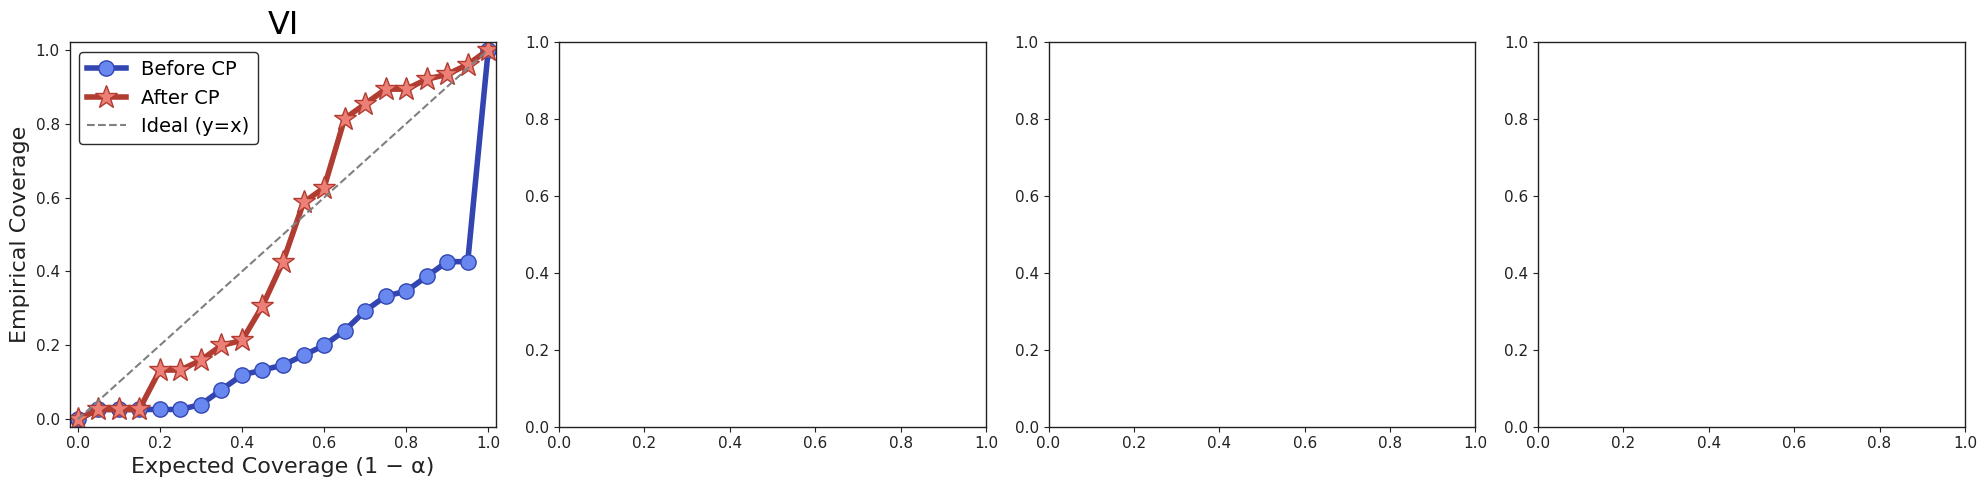

In [18]:
pairs = [
    ("VI",      vi_bpinn_df_uncal, vi_bpinn_df_cal),
]
fig, axs = plot_coverage_grid_2x2(pairs)

In [19]:
# Compute the coverage deviation using mae
def prepare_coverage_data(df):
    expected = 1 - df["alpha"]
    empirical = df["coverage"]
    exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
    emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
    sort_idx = exp_full.argsort()
    exp_sorted, emp_sorted = exp_full[sort_idx], emp_full[sort_idx]
    return exp_sorted.to_numpy(), emp_sorted.to_numpy()

def coverage_deviation(exp, emp, how="mae"):
    diff = np.abs(emp - exp)
    if   how == "mae":  return diff.mean()
    elif how == "rmse": return np.sqrt((diff**2).mean())
    elif how == "max":  return diff.max()
    else:
        raise ValueError("metric must be 'mae', 'rmse', or 'max'")

exp1, emp1 = prepare_coverage_data(vi_bpinn_df_uncal)
exp2, emp2 = prepare_coverage_data(vi_bpinn_df_cal)
dev1 = coverage_deviation(exp1, emp1)  # Using the default metrics
dev2 = coverage_deviation(exp2, emp2)  # Using the default metrics
print(f"Uncal dev:{dev1}")
print(f"Cal dev:{dev2}")

Uncal dev:0.2866666717898278
Cal dev:0.08698412953388124


In [65]:
bar_plot_compare_df = pd.DataFrame({
    'model': {'1':"Before CP", '2': "After CP"},
    'ACD': {'1': 0.2866, '2': 0.0870},
    'Coverage': {'1': 0.43, '2': 0.96},
    'Sharpness': {'1': 0.1886, '2': 0.7403},
})

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_cp_split_bars(df,
                       metrics_group1=('Coverage','Sharpness'),
                       metrics_group2=('ACD',),
                       model_col='model',
                       model_order=('Before CP','After CP'),
                       colors=(COL_NAIV, COL_CP),
                       bar_width_group1=0.35,
                       bar_width_group2=0.20,   # narrower bars for ACD
                       width_ratios=(2,1)):     # adjust subplot widths
    """
    Plot grouped bar charts in two panels:
      - Left: Coverage + Sharpness
      - Right: ACD
    """
    df = df.copy()
    df[model_col] = pd.Categorical(df[model_col], categories=model_order, ordered=True)
    agg = df.groupby(model_col, observed=True).mean(numeric_only=True)

    fig, axs = plt.subplots(1, 2, figsize=(6.5,5),
                            gridspec_kw={'width_ratios': width_ratios})

    def plot_group(ax, metrics, bar_width):
        x = np.arange(len(metrics))
        for i, model in enumerate(model_order):
            ys = [agg.loc[model, m] for m in metrics]
            pos = x + (i-0.5)*bar_width
            bars = ax.bar(pos, ys, width=bar_width, label=model, color=colors[i])
            for rect, y in zip(bars, ys):
                ax.annotate(f"{y:.2f}",
                            xy=(rect.get_x()+rect.get_width()/2, y),
                            xytext=(0,3), textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)
        ax.set_xticks(x, metrics)
        ax.yaxis.grid(True, linestyle=":", alpha=0.6)
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax * 1.10)

    # left: Coverage + Sharpness (use group1 bar width)
    plot_group(axs[0], metrics_group1, bar_width_group1)
    axs[0].set_title(r"Coverage & Sharpness at $\alpha$=0.05")
    axs[0].legend(loc="upper right", frameon=False)

    # right: ACD (use group2 bar width)
    plot_group(axs[1], metrics_group2, bar_width_group2)
    axs[1].set_title("ACD")

    fig.tight_layout()
    # adjust spacing
    fig.subplots_adjust(wspace=0.3) 
    return fig, axs


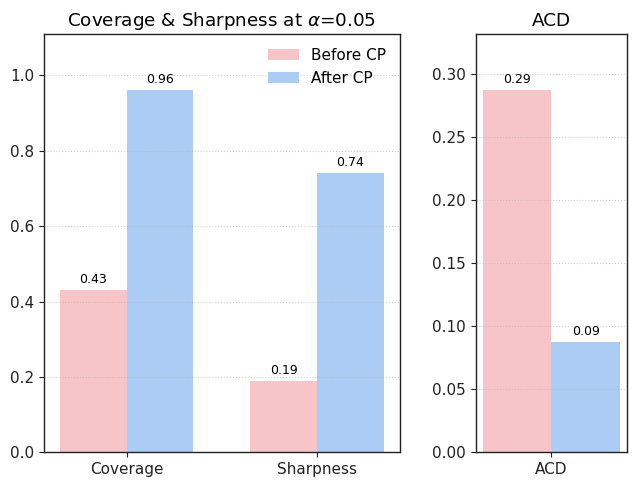

In [158]:
fig, axs = plot_cp_split_bars(
    bar_plot_compare_df,
    bar_width_group1=0.35,  # wider for Coverage/Sharpness
    bar_width_group2=0.1,  # narrower for ACD
    width_ratios=(2,0.85)      # also make ACD panel narrower
)
plt.show()


In [168]:
uncal_predset = vibpinn.predict(alpha, grid_test)
cal_predset = cp_vi.predict(alpha, grid_test, **cp_pred_kwargs)

In [395]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.colors as mcolors

def plot_cp_combined_splitbars(
    df, 
    uncal_predset, cal_predset, grid_test, u_star, X_test, Y_test,
    metrics_group1=('Coverage','Sharpness'),   # left y-axis
    metrics_group2=('ACD',),                   # right y-axis
    model_col='model',
    model_order=('Before CP','After CP'),
    colors=("#f7c5c8","#abccf4"),              # before CP, after CP
    bar_width_group1=0.35,                     # used for all bars (uniform width)
    bar_width_group2=0.2,                     # kept for API compatibility, ignored
    width_ratios=(1.6, 1.4),                   # interval wider, single metrics panel
    figsize=(12,5),
    outdir=None,
    tick_fs=14,
    value_fs=10,
    legend_fs=12,
    y_headroom_left=0.2,                      # extra headroom on left y-axis (15%)
    y_headroom_right=0.2,                     # extra headroom on right y-axis (15%)
    left_tick_color="#590B11",
    right_tick_color="#093458",
    # NEW: shaded fills for the two models
    bar_hatches=("///", "..."),                # Before CP, After CP
    edge_linewidth=0.9                          # outline to make hatches pop
):
    """
    Two panels:
      Left: Interval plot (unchanged)
      Right: Combined metrics bar plot with dual y-axes.
    Bars use different shaded fills (hatches) for Before/After CP.
    Value labels adopt the tick color of their axis (left vs right).
    """

    # ---------- helpers ----------
    def _darker(color, factor=0.75):
        r, g, b = mcolors.to_rgb(color)
        return (r*factor, g*factor, b*factor)

    # ---------- prep bar data ----------
    df = df.copy()
    df[model_col] = pd.Categorical(df[model_col], categories=model_order, ordered=True)
    agg = df.groupby(model_col, observed=True).mean(numeric_only=True)

    # ---------- figure + axes ----------
    fig, axs = plt.subplots(
        1, 2, figsize=figsize,
        gridspec_kw={'width_ratios': width_ratios}
    )
    ax_interval, ax_metrics_left = axs
    ax_metrics_right = ax_metrics_left.twinx()  # right y-axis for group2

    # ---------- Interval plot (unchanged) ----------
    n_lower, n_upper = [arr.ravel() for arr in uncal_predset]
    cp_lower, cp_upper = [arr.ravel() for arr in cal_predset]
    x = np.asarray(grid_test).ravel()
    if len(x) != len(n_lower):
        raise ValueError("grid_test length does not match prediction length.")

    pred_mean = (cp_lower + cp_upper) / 2.0
    true_solution_np = u_star(grid_test).ravel()

    COL_NAIV, COL_CP = colors
    COL_MEAN, COL_TRUE, COL_SCAT, COL_EDGE = "#b13c32", "#222222", "#f6d09f", "#222222"

    ax_interval.fill_between(x, n_lower, n_upper, color=COL_NAIV, alpha=1,
                             label="Before CP", zorder=2)
    ax_interval.fill_between(x, cp_lower, cp_upper, color=COL_CP, alpha=1,
                             label="After CP", zorder=1)
    ax_interval.plot(x, pred_mean, ls="--", lw=2.0, color=COL_MEAN,
                     label="Prediction", zorder=5)
    ax_interval.plot(x, true_solution_np, lw=2.4, color=COL_TRUE,
                     label="True", zorder=3)
    ax_interval.scatter(X_test, Y_test, s=40, facecolor=COL_SCAT, edgecolor=COL_EDGE,
                        linewidth=0.7, label="Data", zorder=4)
    ax_interval.set_xlabel(r"x", fontsize=15)
    ax_interval.set_ylabel(r"$u$", fontsize=15)
    ax_interval.margins(x=0)
    ax_interval.legend(loc="lower center", handlelength=1.6, borderpad=0.6, fontsize=13)
    ymin_i, ymax_i = ax_interval.get_ylim()
    ax_interval.set_ylim(ymin_i, ymax_i*1.10)

    # ---------- Combined metrics bar plot with twin y-axes ----------
    metrics_all = list(metrics_group1) + list(metrics_group2)
    n_metrics = len(metrics_all)
    x_all = np.arange(n_metrics)

    # Use one uniform bar width for all metrics
    bar_w = bar_width_group1
    offset = (np.arange(len(model_order)) - (len(model_order) - 1)/2.0) * bar_w

    # helper to annotate bars with axis-colored text
    def _annotate(ax, bars, values, text_color):
        for rect, y in zip(bars, values):
            ax.annotate(f"{y:.2f}",
                        xy=(rect.get_x() + rect.get_width()/2, y),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=value_fs,
                        color=text_color, zorder=5)

    # Plot bars metric-by-metric, choosing axis based on membership
    left_vals_max = 0.0
    right_vals_max = 0.0
    handles_all, labels_all = [], []

    for mi, metric in enumerate(metrics_all):
        is_left = metric in metrics_group1
        ax_here = ax_metrics_left if is_left else ax_metrics_right
        label_color = left_tick_color if is_left else right_tick_color

        ys_by_model = [agg.loc[model, metric] for model in model_order]

        bars = []
        for i, model in enumerate(model_order):
            xpos = x_all[mi] + offset[i]
            edge_c = _darker(colors[i], 0.72)
            b = ax_here.bar(
                xpos, ys_by_model[i], width=bar_w,
                label=model, color=colors[i],
                hatch=(bar_hatches[i] if i < len(bar_hatches) else None),
                edgecolor=edge_c, linewidth=edge_linewidth, zorder=2
            )
            bars.extend(b)

        _annotate(ax_here, bars, ys_by_model, label_color)

        if is_left:
            left_vals_max = max(left_vals_max, max(ys_by_model))
        else:
            right_vals_max = max(right_vals_max, max(ys_by_model))

        h, l = ax_here.get_legend_handles_labels()
        handles_all += h
        labels_all += l

    # xticks uniformly for all metrics
    ax_metrics_left.set_xticks(x_all, metrics_all, fontsize=tick_fs)

    # y ticks/labels + colors
    ax_metrics_left.set_ylabel("Coverage / Sharpness", fontsize=13, color=left_tick_color,labelpad=8)
    ax_metrics_right.set_ylabel("ACD", fontsize=13, color=right_tick_color,labelpad=8)
    ax_metrics_left.tick_params(axis='y', colors=left_tick_color)
    ax_metrics_right.tick_params(axis='y', colors=right_tick_color)

    # y-lims with extra headroom
    if left_vals_max == 0:
        left_vals_max = 1.0
    if right_vals_max == 0:
        right_vals_max = 1.0
    ax_metrics_left.set_ylim(0, left_vals_max * (1.0 + y_headroom_left))
    ax_metrics_right.set_ylim(0, right_vals_max * (1.0 + y_headroom_right))

    # x-lims so bars aren't cramped
    ax_metrics_left.set_xlim(-0.5, n_metrics - 0.5)

    # deduplicate legend entries
    by_label = {}
    for h, l in zip(handles_all, labels_all):
        if l not in by_label:
            by_label[l] = h
    ax_metrics_left.legend(by_label.values(), by_label.keys(),
                           loc="upper center", frameon=True, fontsize=legend_fs)

    # slight x padding
    ax_metrics_left.margins(x=0.03)

    # layout + save
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.25)

    if outdir:
        os.makedirs(outdir, exist_ok=True)
        fig.savefig(os.path.join(outdir, "combined_dualaxis_uniform.pdf"), bbox_inches="tight")
        fig.savefig(os.path.join(outdir, "combined_dualaxis_uniform.png"), dpi=300, bbox_inches="tight")

    return fig, (ax_interval, ax_metrics_left)


(<Figure size 1200x500 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='$u$'>, <Axes: ylabel='Coverage / Sharpness'>))

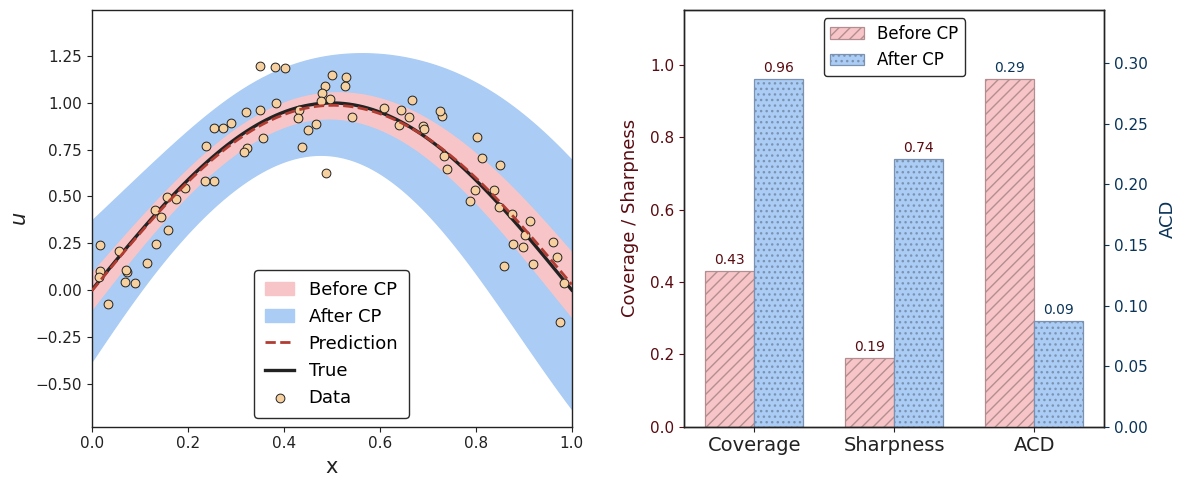

In [396]:
plot_cp_combined_splitbars(
    bar_plot_compare_df, 
    uncal_predset, cal_predset, grid_test, u_star, X_test, Y_test,
)

In [397]:
from utils_tools.utils_tuning import save_plot
save_plot(
    plot_cp_combined_splitbars,
    save_dir="CP_demo", prefix="uncal_vs_cal",
)(
    bar_plot_compare_df, 
    uncal_predset, cal_predset, grid_test, u_star, X_test, Y_test
)

<Figure size 640x480 with 0 Axes>